### Importy

In [151]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

### Wczytanie danych

In [139]:
df = pd.read_csv("../data/final_data.csv", delimiter=';')
df.drop(columns=["id"], inplace=True)

### Dodatkowa analiza rozkładów i outlierów
Cel: Zidentyfikować i zrozumieć, które obserwacje ekstremalne (ceny > pewien próg) wypaczają odchylenie standardowe i R².

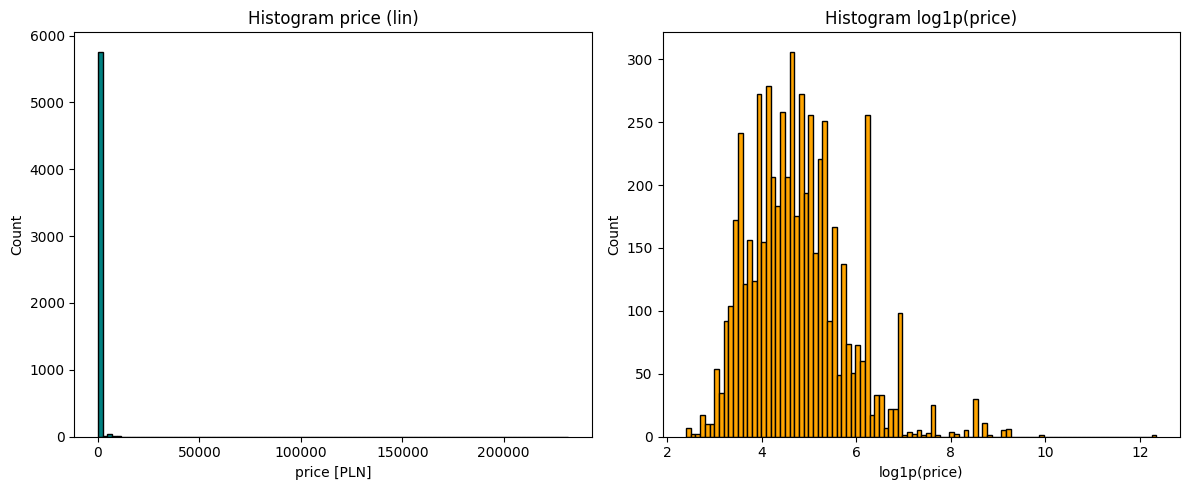

Price > 50 PLN: 76.47% obserwacji
Price > 100 PLN: 49.31% obserwacji
Price > 200 PLN: 23.62% obserwacji
Price > 300 PLN: 15.19% obserwacji
Price > 400 PLN: 11.72% obserwacji
Price > 500 PLN: 7.64% obserwacji
Price > 1000 PLN: 1.91% obserwacji
Price > 2000 PLN: 1.15% obserwacji
Price > 5000 PLN: 0.43% obserwacji


In [140]:
#Histogram cen w skali liniowej i logarytmicznej
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['price'], bins=100, color='teal', edgecolor='black')
plt.title('Histogram price (lin)')
plt.xlabel('price [PLN]')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df['price']), bins=100, color='orange', edgecolor='black')
plt.title('Histogram log1p(price)')
plt.xlabel('log1p(price)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Proporcja ofert powyżej różnych progów
for threshold in [50, 100, 200, 300, 400, 500, 1000, 2000, 5000]:
    pct = (df['price'] > threshold).mean() * 100
    print(f"Price > {threshold} PLN: {pct:.2f}% obserwacji")

### Korelacje cech z log1p(price) i wybór Top 50
Wytypowanie tych cech, które rzeczywiście silnie korelują z ceną – tak, aby nie trenować sieci na wszystkich ~190 kolumnach, tylko skupić się na 50–60 najbardziej znaczących atrybutach. Dzięki temu:

- Mniejsza liczba wejściowych zmiennych da mniej parametrów w sieci → szybsze trenowanie i mniejsze ryzyko overfittingu.

- Sieć nie będzie “rozpraszać się” na cechy niemające realnego wpływu na cenę.

Top 50 cech o najwyższej korelacji z log1p(price):
accommodates                        0.530
property_type_Private room in rental unit 0.507
room_type_Private room              0.468
room_type_Entire home/apt           0.449
property_type_Entire rental unit    0.404
bedrooms                            0.379
bathroom_type_shared                0.373
bathroom_type_unknown               0.324
amenity_Dishwasher                  0.317
amenity_Hair dryer                  0.306
instant_bookable                    0.292
amenity_Air conditioning            0.288
amenity_Lock on bedroom door        0.282
amenity_Crib                        0.274
beds                                0.261
amenity_Oven                        0.250
amenity_Hot water kettle            0.229
amenity_Toaster                     0.226
amenity_Microwave                   0.220
amenity_Coffee maker                0.219
amenity_Iron                        0.218
amenity_Bed linens                  0.217
amenity_Refrigerato

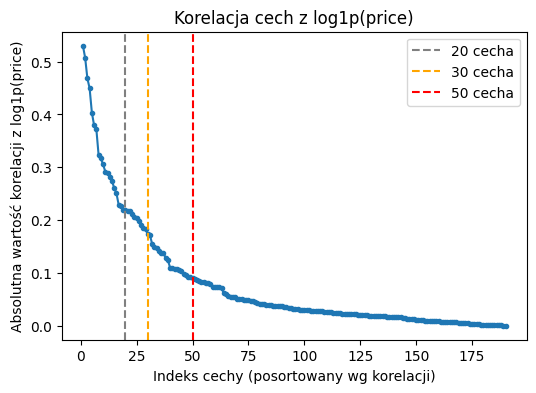

In [141]:
# Najpierw zapewniamy, że cena jest w logarytmie, bo rozkład jest mocno skośny:
price_log = np.log1p(df["price"])

# Obliczamy korelację bezwzględną każdej cechy z log1p(price)
# (pomijamy kolumny, których nie chcemy brać pod uwagę, np. 'id', samą 'price' czy 'is_premium')
corrs = []
for col in df.columns:
    if col in ["id", "price", "is_premium"]:
        continue
    # bierzemy tylko cechy numeryczne (float lub int)
    if pd.api.types.is_numeric_dtype(df[col]):
        # obliczamy korelację Pearsona między df[col] a price_log
        c = np.corrcoef(df[col], price_log, rowvar=False)[0, 1]
        corrs.append((col, abs(c)))

# Sortujemy według wartości korelacji malejąco i wyświetlamy top 20
corrs_sorted = sorted(corrs, key=lambda x: x[1], reverse=True)

print("Top 50 cech o najwyższej korelacji z log1p(price):")
for col, cval in corrs_sorted[:50]:
    print(f"{col:<35} {cval:.3f}")

# Następnie wybieramy, powiedzmy, Top 50 najbardziej skorelowanych cech
top_k = [col for col, _ in corrs_sorted[:50]]
print(f"\nWybrano {len(top_k)} cech jako Top 50.")

# Zapiszmy je do zmiennej X (będziemy trenować na tych cechach)
X = df[top_k].copy()

# A target (y) to log1p(price) (ew. price, jeśli będziesz trenować na surowych wartościach)
y = price_log.copy()

# Sprawdźmy rozmiary:
print("\nKształt X:", X.shape)
print("Kształt y:", y.shape)

# Przygotuj listę samych wartości korelacji w kolejności malejącej:
corr_values = [c for _, c in corrs_sorted]

plt.figure(figsize=(6,4))
plt.plot(range(1, len(corr_values)+1), corr_values, marker='o', markersize=3)
plt.axvline(20, color='gray', linestyle='--', label='20 cecha')
plt.axvline(30, color='orange', linestyle='--', label='30 cecha')
plt.axvline(50, color='red', linestyle='--', label='50 cecha')
plt.xlabel('Indeks cechy (posortowany wg korelacji)')
plt.ylabel('Absolutna wartość korelacji z log1p(price)')
plt.title('Korelacja cech z log1p(price)')
plt.legend()
plt.show()



### Opcje dla outlierów: segmentacja lub ważenie
Cel: Zdecydować, czy tworzyć osobne podejście dla „premium” ofert, czy ważyć stratę tak, by model zwracał większą uwagę na drogie ogłoszenia

In [142]:
# Definiujemy próg premium – na przykład >1000 PLN
premium_threshold = 1000

df['is_premium'] = (df['price'] > premium_threshold).astype(int)

print("Liczba premium ofert (>1000 PLN):", df['is_premium'].sum(), "/", len(df))
print(f"Udział: {df['is_premium'].mean() * 100:.2f}%")

Liczba premium ofert (>1000 PLN): 111 / 5826
Udział: 1.91%


### Feature engineering 
nowa interakcja accommodates × bedrooms

In [143]:
df["acc_bed"] = df["accommodates"] * df["bedrooms"]

### Redukcja rzadkich kategorii
połącz te z <10 wystąpień w "Other"

In [144]:
for col in df.select_dtypes(include='object').columns:
    freq = df[col].value_counts()
    rare = freq[freq < 10].index
    df[col] = df[col].replace(rare, "Other")

### Standaryzacja cech

In [145]:
scaler = StandardScaler()

### Podział na zbiory

In [146]:
# 1. Podział 80% train+val, 20% test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X.values,      # Upewnij się, że X jest teraz np.ndarray (np. df[top_k].values)
    y.values,      # y = np.log1p(df["price"])
    test_size=0.20,
    random_state=42,
    shuffle=True
)

# 2. Podział train+val na 75% train, 25% val (czyli 60/20/20 całego zbioru)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval,
    y_trainval,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

print(f"Rozmiary: Train={X_train.shape[0]}, Val={X_val.shape[0]}, Test={X_test.shape[0]}")

# 3. Skalowanie cech – uczymy scaler na X_train, potem transformujemy val i test:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# 4. Zamieniamy na tensory (float32) i robimy DataLoadery
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1),    dtype=torch.float32)

X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val.reshape(-1, 1),    dtype=torch.float32)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test.reshape(-1, 1),    dtype=torch.float32)

batch_size = 32

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t,   y_val_t),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=batch_size, shuffle=False)

# Mały sanity check:
xb, yb = next(iter(train_loader))
print("Przykładowy batch: X batch:", xb.shape, "y batch:", yb.shape)


Rozmiary: Train=3495, Val=1165, Test=1166
Przykładowy batch: X batch: torch.Size([32, 50]) y batch: torch.Size([32, 1])


### Konwersja do tensorów

In [148]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val,   dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor   = torch.tensor(y_val,   dtype=torch.float32).view(-1, 1)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.float32).view(-1, 1)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor,   y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False)

### Definicja architektury MLP 
(głębsza, mniejszy dropout)

In [149]:
class MLP_50(nn.Module):
    def __init__(self, input_dim=50):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

### Inicjalizacja modelu i konfiguracja uczenia

In [152]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Urządzenie:", device)

# 1. Instancja sieci MLP_50 (input_dim = liczba cech = 50)
model = MLP_50(input_dim=X_train_t.shape[1]).to(device)

# 2. Funkcja straty: MSE na log1p(price) (czyli MSLE w oryginale)
loss_fn = nn.MSELoss()

# 3. Optimizer i scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=50,         # np. 50 epok
    pct_start=0.3,
    div_factor=25.0,
    final_div_factor=1e4
)

print(model)


Urządzenie: cuda
MLP_50(
  (net): Sequential(
    (0): Linear(in_features=50, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)


### Trening z walidacją i early stopping

In [153]:
num_epochs = 50
best_val_r2 = -np.inf
epochs_no_improve = 0
patience = 10  # gdy przez 10 epok brak poprawy R², przerwij

# Funkcja trenowania jednej epoki
def train_one_epoch(model, loader, optimizer, loss_fn, scheduler):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

# Funkcja ewaluacji (walidacja/test)
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_trues = []
    total_loss = 0.0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = loss_fn(preds, yb)
        total_loss += loss.item() * xb.size(0)
        all_preds.append(preds.cpu().numpy())
        all_trues.append(yb.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    all_preds = np.concatenate(all_preds).flatten()
    all_trues = np.concatenate(all_trues).flatten()

    # Zamiana z log1p na surową skalę
    all_preds_exp = np.expm1(all_preds)
    all_trues_exp = np.expm1(all_trues)

    r2   = r2_score(all_trues_exp, all_preds_exp)
    mae  = mean_absolute_error(all_trues_exp, all_preds_exp)
    rmse = np.sqrt(mean_squared_error(all_trues_exp, all_preds_exp))
    return avg_loss, r2, mae, rmse

# Właściwa pętla trenowania:
for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, scheduler)
    val_loss, val_r2, val_mae, val_rmse = evaluate(model, val_loader)

    print(f"Epoka {epoch:02d} | "
          f"Train loss (MSE log) = {train_loss:.4f} | "
          f"Val loss (MSE log) = {val_loss:.4f} | "
          f"Val R² = {val_r2:.4f} | Val MAE = {val_mae:.2f} PLN | Val RMSE = {val_rmse:.2f} PLN")

    # Early stopping wg R²:
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        torch.save(model.state_dict(), "best_model_50.pth")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"\nBrak poprawy R² przez {patience} epok → kończę trening.")
        break

# Po zakończeniu treningu ładujemy najlepszy model:
model.load_state_dict(torch.load("best_model_50.pth", map_location=device))


Epoka 01 | Train loss (MSE log) = 24.8513 | Val loss (MSE log) = 27.4069 | Val R² = -0.1226 | Val MAE = 238.64 PLN | Val RMSE = 721.43 PLN
Epoka 02 | Train loss (MSE log) = 24.5857 | Val loss (MSE log) = 26.2883 | Val R² = -0.1221 | Val MAE = 238.50 PLN | Val RMSE = 721.30 PLN
Epoka 03 | Train loss (MSE log) = 24.2976 | Val loss (MSE log) = 25.3796 | Val R² = -0.1217 | Val MAE = 238.33 PLN | Val RMSE = 721.15 PLN


Epoka 04 | Train loss (MSE log) = 23.8102 | Val loss (MSE log) = 24.9400 | Val R² = -0.1218 | Val MAE = 238.32 PLN | Val RMSE = 721.18 PLN
Epoka 05 | Train loss (MSE log) = 23.4105 | Val loss (MSE log) = 24.4219 | Val R² = -0.1219 | Val MAE = 238.29 PLN | Val RMSE = 721.22 PLN
Epoka 06 | Train loss (MSE log) = 22.6677 | Val loss (MSE log) = 24.2933 | Val R² = -0.1220 | Val MAE = 238.33 PLN | Val RMSE = 721.24 PLN
Epoka 07 | Train loss (MSE log) = 21.7022 | Val loss (MSE log) = 22.5956 | Val R² = -0.1216 | Val MAE = 238.09 PLN | Val RMSE = 721.13 PLN
Epoka 08 | Train loss (MSE log) = 19.9997 | Val loss (MSE log) = 20.2582 | Val R² = -0.1204 | Val MAE = 237.55 PLN | Val RMSE = 720.75 PLN
Epoka 09 | Train loss (MSE log) = 17.4102 | Val loss (MSE log) = 16.6817 | Val R² = -0.1186 | Val MAE = 236.55 PLN | Val RMSE = 720.16 PLN
Epoka 10 | Train loss (MSE log) = 13.6066 | Val loss (MSE log) = 12.3948 | Val R² = -0.1272 | Val MAE = 236.62 PLN | Val RMSE = 722.93 PLN
Epoka 11 | Train loss (MSE 

<All keys matched successfully>

In [154]:
# ------------------------------------------------------------
# Funkcja trenowania jednej epoki (musiała być wcześniej w notebooku,
# ale w razie potrzeby wklej poniżej, żeby mieć pewność, że jest zdefiniowana).
# ------------------------------------------------------------
def train_one_epoch(model, loader, optimizer, loss_fn, scheduler, device):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

# ------------------------------------------------------------
# Funkcja ewaluacji (walidacja lub test). Zwraca:
# (średnie MSE na log-skalach, R² w oryginalnych PLN, MAE w PLN, RMSE w PLN).
# ------------------------------------------------------------
@torch.no_grad()
def evaluate(model, loader, device, train_on_log=True):
    model.eval()
    all_preds = []
    all_trues = []
    total_loss = 0.0

    # Jeśli korzystasz z MSELoss na log1p(price), to train_on_log=True
    # W przypadku trenowania na surowej cenie z HuberLoss, ustaw train_on_log=False
    loss_fn = nn.MSELoss() if train_on_log else nn.SmoothL1Loss(beta=1.0)

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = loss_fn(preds, yb)
        total_loss += loss.item() * xb.size(0)
        all_preds.append(preds.cpu().numpy())
        all_trues.append(yb.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    all_preds = np.concatenate(all_preds).flatten()
    all_trues = np.concatenate(all_trues).flatten()

    if train_on_log:
        # Zamiana z log1p → surowa skala
        preds_exp = np.expm1(all_preds)
        trues_exp = np.expm1(all_trues)
    else:
        preds_exp = all_preds
        trues_exp = all_trues

    # Metryki w oryginalnej (PLN) skali
    r2   = r2_score(trues_exp, preds_exp)
    mae  = mean_absolute_error(trues_exp, preds_exp)
    rmse = np.sqrt(mean_squared_error(trues_exp, preds_exp))
    return avg_loss, r2, mae, rmse

### Kontekst do wyników

In [155]:
df = pd.read_csv("../data/final_data.csv", delimiter=";")
y = df["price"]

print("Średnia price:", y.mean())
print("Odchylenie std price:", y.std())

Średnia price: 283.02428767593545
Odchylenie std price: 3115.061399068716


### Test

In [158]:
# Najpierw zbierzemy wszystkie predykcje i „prawdziwe” y w log-skalach (żeby zobaczyć, co się dzieje
# tuż przed expm1). Nie wykonujemy od razu r2_score – tylko sprawdzimy, czy są nan/inf.
all_preds = []
all_trues = []

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        all_preds.append(preds.cpu().numpy().flatten())
        all_trues.append(yb.cpu().numpy().flatten())

all_preds = np.concatenate(all_preds)
all_trues = np.concatenate(all_trues)

# Sprawdzamy, czy są NaN lub inf w log-skalach
n_nan_preds   = np.isnan(all_preds).sum()
n_inf_preds   = np.isinf(all_preds).sum()
n_nan_trues   = np.isnan(all_trues).sum()
n_inf_trues   = np.isinf(all_trues).sum()

print(f"Predykcje (log-scale)  — NaN: {n_nan_preds}, inf: {n_inf_preds}")
print(f"Prawdziwe y  (log-scale) — NaN: {n_nan_trues}, inf: {n_inf_trues}")

# Dodatkowo sprawdźmy, czy po expm1 robią się inf lub zbyt duże liczby
preds_exp = np.expm1(all_preds)
trues_exp = np.expm1(all_trues)

# Zliczamy nan/inf po odwróceniu log1p
n_nan_preds_exp = np.isnan(preds_exp).sum()
n_inf_preds_exp = np.isinf(preds_exp).sum()
n_nan_trues_exp = np.isnan(trues_exp).sum()
n_inf_trues_exp = np.isinf(trues_exp).sum()

print(f"Predykcje (PLN)       — NaN: {n_nan_preds_exp}, inf: {n_inf_preds_exp}")
print(f"Prawdziwe y  (PLN)    — NaN: {n_nan_trues_exp}, inf: {n_inf_trues_exp}")

# Jeżeli są jakieś nienormalne wartości, zobaczmy ich zakres:
if n_inf_preds > 0 or n_inf_preds_exp > 0:
    # Wyświetlamy kilka największych predykcji w log-skalach
    idx_inf = np.where(np.isinf(all_preds))[0]
    print("Kilka indeksów, gdzie predykcja (log) = inf:", idx_inf[:5])
if n_inf_preds_exp > 0:
    idx_inf_exp = np.where(np.isinf(preds_exp))[0]
    print("Kilka indeksów, gdzie predykcja (PLN) = inf:", idx_inf_exp[:5])

# Możesz też sprawdzić maksymalne wartości:
print("Max predykcja (log):", np.nanmax(all_preds))
print("Min predykcja (log):", np.nanmin(all_preds))
print("Max predykcja (PLN):", np.nanmax(preds_exp))
print("Min predykcja (PLN):", np.nanmin(preds_exp))


Predykcje (log-scale)  — NaN: 0, inf: 0
Prawdziwe y  (log-scale) — NaN: 0, inf: 0
Predykcje (PLN)       — NaN: 0, inf: 5
Prawdziwe y  (PLN)    — NaN: 0, inf: 0
Kilka indeksów, gdzie predykcja (log) = inf: []
Kilka indeksów, gdzie predykcja (PLN) = inf: [ 442  768  822  960 1082]
Max predykcja (log): 97.10179
Min predykcja (log): -2.591182
Max predykcja (PLN): inf
Min predykcja (PLN): -0.92506856


/tmp/ipykernel_53374/1742198974.py:27: RuntimeWarning: overflow encountered in expm1
  preds_exp = np.expm1(all_preds)


### Ewaluacja

In [159]:
test_loss, test_r2, test_mae, test_rmse = evaluate(model, test_loader, device)
print("\n=== Wyniki na zbiorze testowym ===")
print(f"Test loss (MSE log) = {test_loss:.4f}")
print(f"Test R²            = {test_r2:.4f}")
print(f"Test MAE           = {test_mae:.2f} PLN")
print(f"Test RMSE          = {test_rmse:.2f} PLN")

# Dodatkowo: scatter plot y_true vs y_pred
import matplotlib.pyplot as plt

# Używamy evaluate(), ale żeby narysować wykres:
model.eval()
all_preds = []; all_trues = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        all_preds.append(preds.cpu().numpy().flatten())
        all_trues.append(yb.cpu().numpy().flatten())

all_preds = np.concatenate(all_preds)
all_trues = np.concatenate(all_trues)
all_preds_exp = np.expm1(all_preds)
all_trues_exp = np.expm1(all_trues)

plt.figure(figsize=(8, 6))
plt.scatter(all_trues_exp, all_preds_exp, alpha=0.3)
plt.xlabel("Rzeczywista cena [PLN]")
plt.ylabel("Predykcja [PLN]")
plt.title("Predykcja vs Rzeczywista cena (zb. testowe)")
lim = max(all_trues_exp.max(), all_preds_exp.max()) * 1.05
plt.plot([0, lim], [0, lim], color="red", ls="--")
plt.show()


/tmp/ipykernel_53374/1028024415.py:49: RuntimeWarning: overflow encountered in expm1
  preds_exp = np.expm1(all_preds)


ValueError: Input contains infinity or a value too large for dtype('float32').

### Wykres: predykcja vs rzeczywista cena

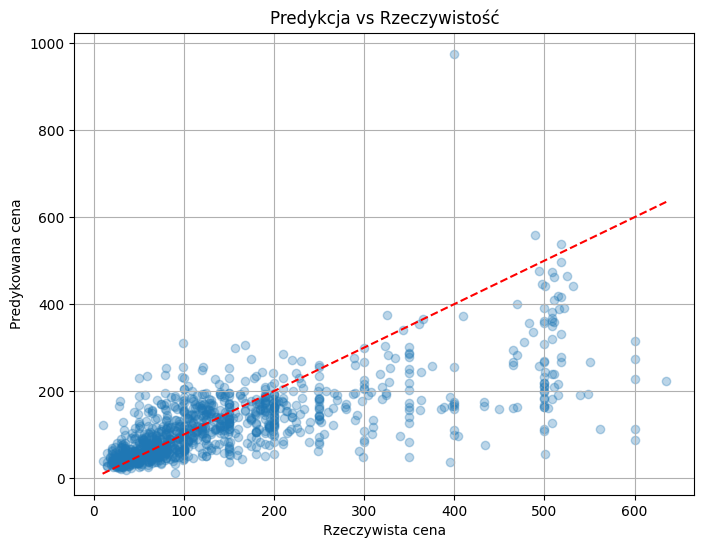

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_exp, y_pred_exp, alpha=0.3)
plt.plot(
    [y_test_exp.min(), y_test_exp.max()],
    [y_test_exp.min(), y_test_exp.max()],
    "--r",
)
plt.xlabel("Rzeczywista cena")
plt.ylabel("Predykowana cena")
plt.title("Predykcja vs Rzeczywistość")
plt.grid(True)
plt.show()